In [ ]:
if (!require(survival)) 
    install.packages("survival")
if (!require(survminer)) 
    install.packages("survminer")
if (!require(HDInterval)) 
    install.packages("HDInterval")

Loading required package: survival

Loading required package: survminer

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Loading required package: HDInterval

Warning message:
“package ‘HDInterval’ was built under R version 4.3.3”


In [ ]:
library(survival)
library(survminer)
library(dplyr)

library(HDInterval)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Problem 2 - Simulation

In [ ]:
# Parameters
N <- 75       # Total population
p <- 0.05     # Infection probability
chains <- 1000  # Number of simulations
iterations <- 300  # Number of iterations per simulation

# Function to simulate one chain
simulate_chain <- function(N, p, iterations) {
  # Initial infected count
  infected <- numeric(iterations)
  infected[1] <- 1  # Start with 1 infected
  
  for (t in 2:iterations) {
    k <- infected[t - 1]
    # If everyone is infected, stay there
    if (k >= N) {
      infected[t] <- N
    } else {
      # Probability that new person gets infected
      prob_new_infection <- 1 - (1 - p)^k
      # Bernoulli trial: did the new person get infected?
      new_infections <- rbinom(1, 1, prob_new_infection)
      infected[t] <- k + new_infections
    }
  }
  
  return(infected)
}

In [ ]:
# Run simulations
set.seed(42)  # For reproducibility
results <- replicate(chains, simulate_chain(N, p, iterations))

# Find, for each chain, the first time step where everyone is infected
times_to_full_infection <- apply(results, 2, function(chain) {
  which(chain == N)[1]  # First time the entire population is infected
})

# Average over all chains
average_time <- mean(times_to_full_infection)
cat("Average time to full infection:", average_time, "\n")

# Theoretical time from part (b)
theoretical_time <- sum(1 / (1 - (1 - p)^(1:(N - 1))))
cat("Theoretical time from formula:", theoretical_time, "\n")


Average time to full infection: 142.254 
Theoretical time from formula: 142.9774 


### Problem 4

#### 4a

In [ ]:
# Load the data
cats <- read.csv("./data/AustinCats.csv")
cats |> head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age,adopt
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7,0
2,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1,0
3,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2,1
4,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12,0
5,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1,0
6,A756485,4,08/24/2017 05:34:00 PM,Adoption,08/20/2017 03:07:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,1,1


In [ ]:
cats <- cats |>
  mutate(
    # Censoring variable: 1 if Adoption, 0 otherwise
    event = ifelse(out_event == "Adoption", 1, 0),
    
    # Color variable: 1 if Black, 2 otherwise
    color_bin = ifelse(color == "Black", 1, 2),
    
    # Time handling: cap days_to_event at 365
    days_to_event = ifelse(days_to_event > 365, 365, days_to_event),
    
    # If capped at 365, event is 0 (censored)
    event = ifelse(days_to_event > 365, 0, event)
  )

# Cross-check: average adoption time for non-censored cats
mean_adoption_time <- cats |> 
  filter(event == 1) |>
  summarise(mean_time = mean(days_to_event)) |>
  pull(mean_time)

cat("Average adoption time for non-censored cats:", mean_adoption_time, "\n")

Average adoption time for non-censored cats: 37.93067 


In [ ]:
cats |> head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age,adopt,event,color_bin
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
1,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7,0,0,2
2,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1,0,0,2
3,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2,1,1,2
4,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12,0,0,2
5,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1,0,0,2
6,A756485,4,08/24/2017 05:34:00 PM,Adoption,08/20/2017 03:07:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,1,1,1,2


#### 4b

  time  survival
1   30 0.5644157


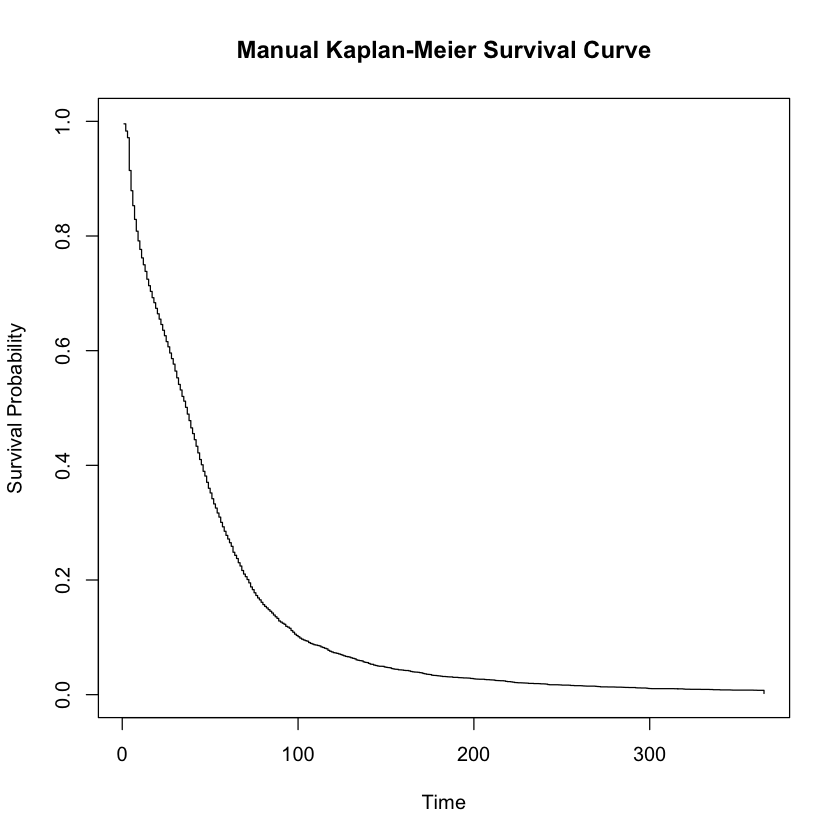

In [ ]:
# Part (b) - Manual Survival probability
# Unique event times
event_times <- sort(unique(cats$days_to_event[cats$event == 1]))

# Initialize variables
n <- nrow(cats)
survival <- 1
surv_probs <- numeric(length(event_times))
at_risk <- n

# Kaplan-Meier estimator
for (i in seq_along(event_times)) {
  t <- event_times[i]
  # Number of events at time t
  d_i <- sum(cats$days_to_event == t & cats$event == 1)
  # Number at risk just before time t
  n_i <- sum(cats$days_to_event >= t)
  # Update survival probability
  survival <- survival * (1 - d_i / n_i)
  surv_probs[i] <- survival
}

# Combine results
km_df <- data.frame(
  time = event_times,
  survival = surv_probs
)

plot(km_df$time, km_df$survival, type = "s", 
     xlab = "Time", ylab = "Survival Probability",
     main = "Manual Kaplan-Meier Survival Curve", ylim = c(0, 1))

km_df |> 
    filter(time == 30) |>
    print()


Call: survfit(formula = surv_obj ~ 1)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
   30   6277    6198    0.564 0.00434        0.556        0.573

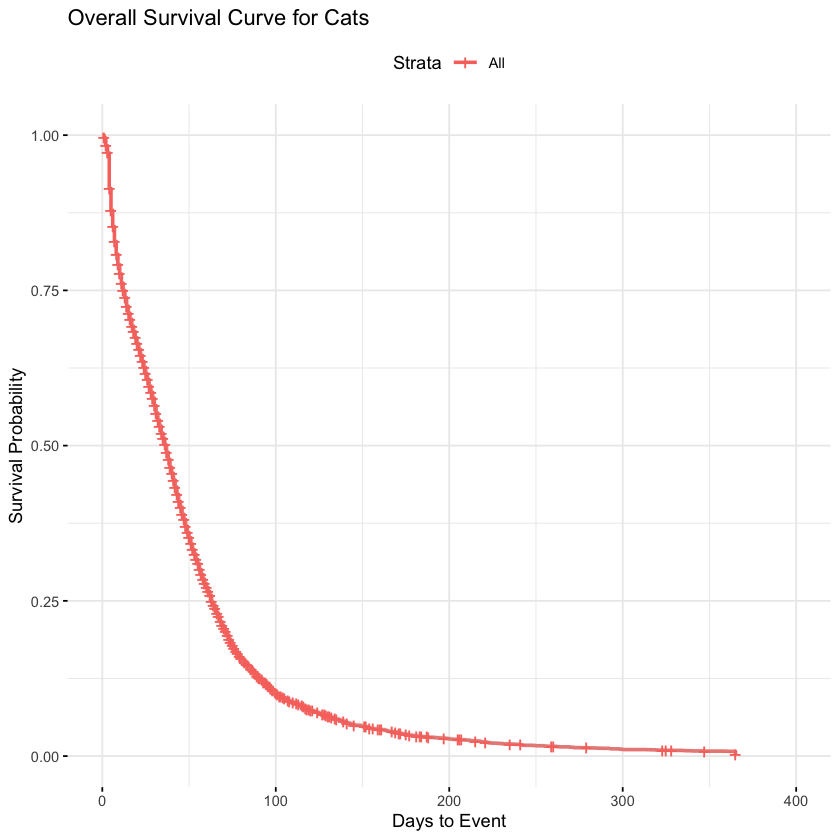

In [ ]:
# Part (b) - Survival probability
# Survival object
surv_obj <- Surv(time = cats$days_to_event, event = cats$event)

# Fit Kaplan-Meier survival curve
km_fit <- survfit(surv_obj ~ 1)

# Plot overall survival curve
ggsurvplot(km_fit, data = cats, conf.int = TRUE, ggtheme = theme_minimal(),
           title = "Overall Survival Curve for Cats",
           xlab = "Days to Event", ylab = "Survival Probability")

# Cross-check survival probability at 30 days
summary(km_fit, times = 30)

Call:
survdiff(formula = surv_obj ~ color_bin, data = cats)

                N Observed Expected (O-E)^2/E (O-E)^2/V
color_bin=1  2965     1445     1707     40.33      48.8
color_bin=2 19391     9906     9644      7.14      48.8

 Chisq= 48.8  on 1 degrees of freedom, p= 3e-12 


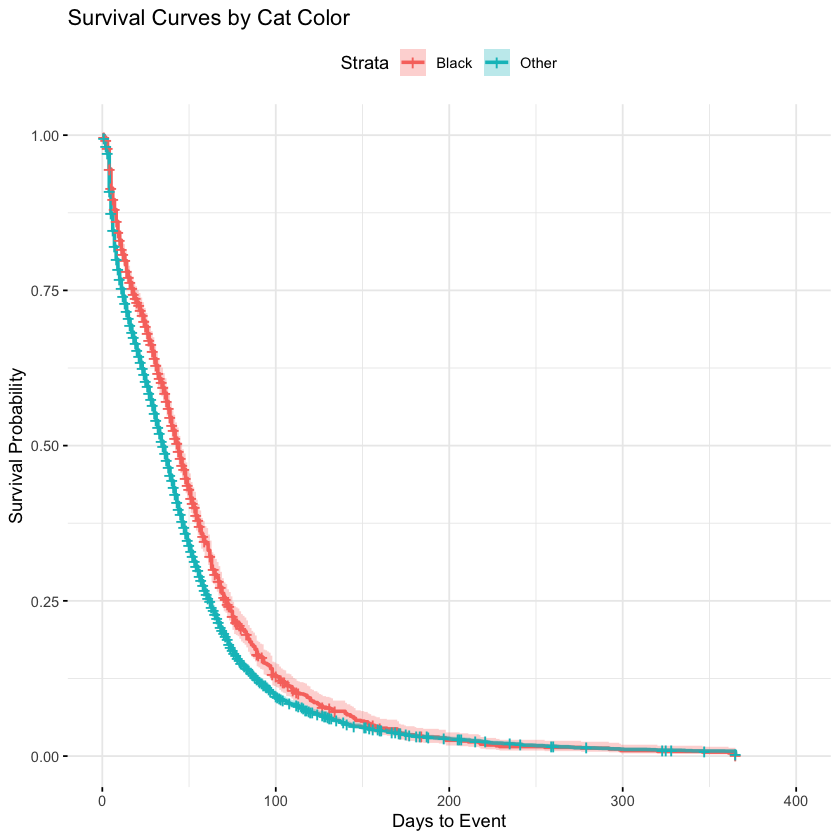

In [ ]:
# Part (c) - Survival curves by color
km_color_fit <- survfit(surv_obj ~ color_bin, data = cats)

# Plot survival curves by color
ggsurvplot(km_color_fit, conf.int = TRUE, ggtheme = theme_minimal(),
           title = "Survival Curves by Cat Color",
           xlab = "Days to Event", ylab = "Survival Probability",
           legend.labs = c("Black", "Other"))

# Log-rank test to compare survival curves
log_rank_test <- survdiff(surv_obj ~ color_bin, data = cats)
print(log_rank_test)

In [ ]:
# Part (d) - Cox proportional hazards model
cox_model <- coxph(surv_obj ~ color_bin + intake_age, data = cats)
summary(cox_model)

Call:
coxph(formula = surv_obj ~ color_bin + intake_age, data = cats)

  n= 22356, number of events= 11351 

                coef exp(coef)  se(coef)       z Pr(>|z|)    
color_bin   0.220299  1.246449  0.028194   7.814 5.55e-15 ***
intake_age -0.006386  0.993634  0.000365 -17.495  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
color_bin     1.2464     0.8023    1.1794    1.3173
intake_age    0.9936     1.0064    0.9929    0.9943

Concordance= 0.554  (se = 0.003 )
Likelihood ratio test= 422.9  on 2 df,   p=<2e-16
Wald test            = 357.4  on 2 df,   p=<2e-16
Score (logrank) test = 364.5  on 2 df,   p=<2e-16


### Problem 5

#### 5a

In [ ]:
thetas <- 0:5 / 6
x <- 13
posterior <- thetas * (1 - thetas) ^ (x - 1)
prob <- posterior / sum(posterior)
est <- sum(thetas * prob)
est

[1] 0.1886212

#### 5c

Posterior alpha: 16 
Posterior beta: 51 
Posterior mean estimate of θ: 0.238806 


Warning message in title(...):
“conversion failure on 'Posterior PDF of θ' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in title(...):
“conversion failure on 'Posterior PDF of θ' in 'mbcsToSbcs': dot substituted for <b8>”


95% HPDI for θ: 0.1407022 0.3412805 


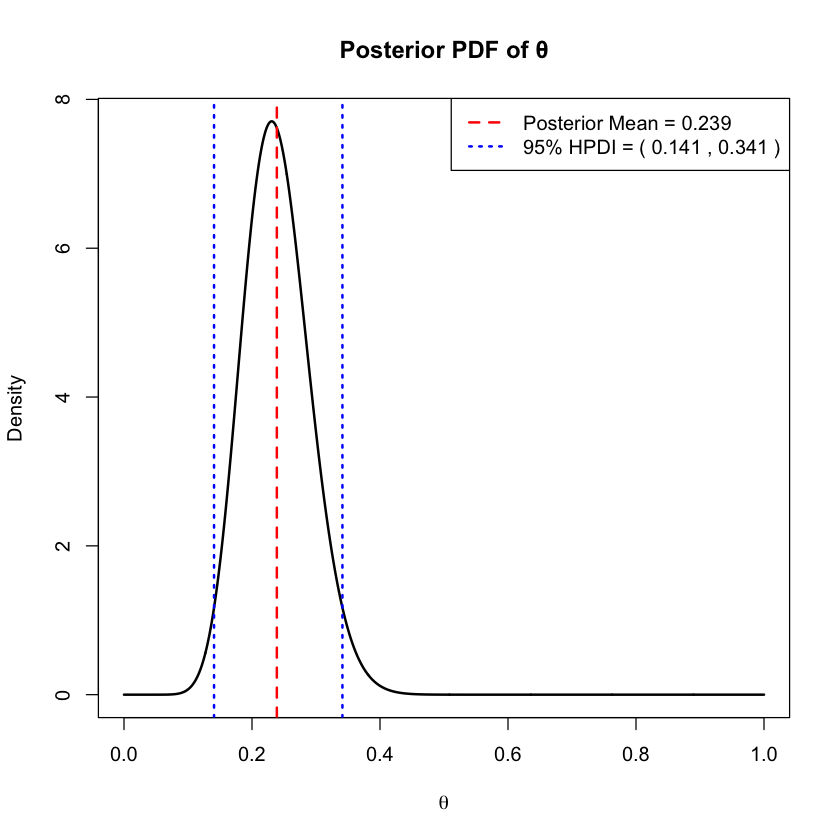

In [ ]:
# Sample data
sample_data <- c(20, 1, 2, 14, 1, 5, 2, 3, 9, 2)

# Prior hyperparameters
alpha_prior <- 6
beta_prior <- 2

# Sufficient statistics
n <- length(sample_data)
sum_x <- sum(sample_data)

# Posterior hyperparameters
alpha_post <- alpha_prior + n
beta_post <- beta_prior + sum_x - n

cat("Posterior alpha:", alpha_post, "\n")
cat("Posterior beta:", beta_post, "\n")

# Posterior mean (estimator of θ)
posterior_mean <- alpha_post / (alpha_post + beta_post)
cat("Posterior mean estimate of θ:", posterior_mean, "\n")

# Define posterior density function
theta_vals <- seq(0, 1, length.out = 1000)
posterior_density <- dbeta(theta_vals, alpha_post, beta_post)

# Plot posterior density
plot(theta_vals, posterior_density, type = "l", lwd = 2,
     main = "Posterior PDF of θ", xlab = expression(theta), ylab = "Density")
abline(v = posterior_mean, col = "red", lwd = 2, lty = 2)

# Compute 95% HPDI
hpdi_interval <- hdi(qbeta, shape1 = alpha_post, shape2 = beta_post, credMass = 0.95)
cat("95% HPDI for θ:", hpdi_interval, "\n")

# Add HPDI to plot
abline(v = hpdi_interval, col = "blue", lwd = 2, lty = 3)
legend("topright", legend = c(paste("Posterior Mean =", round(posterior_mean, 3)),
                              paste("95% HPDI = (", round(hpdi_interval[1], 3), ",", round(hpdi_interval[2], 3), ")")),
       col = c("red", "blue"), lwd = 2, lty = c(2, 3))

